# Proof of Concept for Iris

## Summary

Train a classifier on the iris dataset. Use this as an example for training and deploying models.



# Imports

In [1]:
from collections import OrderedDict
import os
import importlib
import json
import logging
import pickle
import sys


import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn import (
    datasets,
    tree,
    metrics,
    naive_bayes,
    svm,
    linear_model,
)

# from ds_cli import config

In [2]:
# TODO: add this to PYTHONPATH. It's the module code for the project.
# sys.path.append(os.path.join(config.root_path, 'projects/poc'))

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import src

In [30]:
ROOT_PATH = os.path.abspath(os.path.join(src.__file__, '..'))


logger = logging.getLogger(__name__)
logging.basicConfig(level='DEBUG')
logging.getLogger('matplotlib').setLevel('CRITICAL')

# Data

In [6]:
def get_data():
    """ Get the data and return dataframe   
    """
    raw = sk.datasets.load_iris(return_X_y=False)


    columns = [
        f.replace('(cm)', 'cm').replace(' ', '_')
        for f in raw['feature_names']
    ]
    df_iris = pd.DataFrame(raw['data'], columns=columns)
    df_iris['species_encoded'] = raw['target']
    return df_iris

In [7]:
df_iris = get_data()

In [8]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
 4   species_encoded  150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


# Exploration

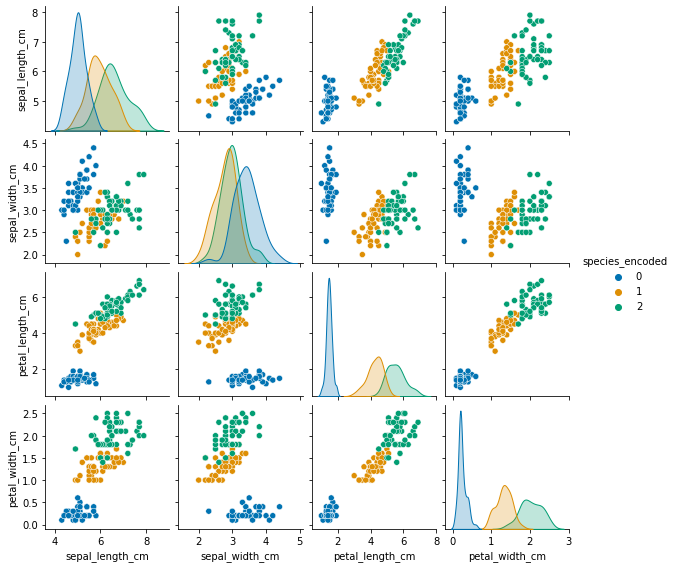

In [9]:
sns.pairplot(df_iris, hue="species_encoded", height = 2, palette = 'colorblind');

In [10]:
def t_test_score(x, t_mean, t_std):
    n = len(x)
    return (x.mean() - t_mean) / (t_std / np.sqrt(n))
    

In [11]:
def validate_data(df_iris):
    """ Do checks on the input data
    """
    features = OrderedDict([
        ('sepal_length_cm', {
            'validation': {
                't_mean': 5.84,
                't_std': 0.828,
            }
        }),
        ('sepal_width_cm', {
            'validation': {
                't_mean': 3.057,
                't_std': 0.435,
            }
        }),
        ('petal_length_cm', {
            'validation': {
                't_mean': 3.758,
                't_std': 1.765,
            }
        }),  
        ('petal_width_cm', {
            'validation': {
                't_mean': 1.199,
                't_std': 0.762,
            }
        }),          
    ])

    for col in features:
        validation = features[col]['validation']
        x = df_iris[col]
        t = t_test_score(x, validation['t_mean'], validation['t_std'])
        if t > 0.1:
            raise ValueError(f'Data column {col} failed t test with {t} > 0.1')
            
    unique_values = set(df_iris['species_encoded'].unique())
    if unique_values != {0, 1, 2}:
        raise ValueError(f'Values have different encoding {unique_values}')
    
    logger.info('Input data matches expectations')
    

In [12]:
validate_data(df_iris)

INFO:__main__:Input data matches expectations


## Featurize

In [13]:
meta = {
    'features': ['sepal_length_cm_norm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm'],
}

In [14]:
def min_max_clip(x, xmin, xmax):
    norm = (x - xmin) / (xmax - xmin)
    return np.clip(norm, 0, 1)

In [15]:
def create_features(df_iris):
    X = pd.DataFrame()        

    X['sepal_length_cm_norm'] = min_max_clip(df_iris['sepal_length_cm'], 0, 10)
    X['sepal_width_cm'] = df_iris['sepal_width_cm']
    X['petal_length_cm'] = df_iris['petal_length_cm']
    X['petal_width_cm'] = df_iris['petal_width_cm']
    return X
    
def create_target(df_iris):
    return df_iris['species_encoded']
    

In [16]:
X_features = create_features(df_iris)
y_features = create_target(df_iris)

# Training Split

In [17]:
def validate_test_train(test_train):
    t = test_train
    X_train, y_train = t['train']['X'], t['train']['y']
    X_test, y_test = t['test']['X'], t['test']['y']    
    
    percent_targets = y_train.value_counts() / len(y_train) - y_test.value_counts() / len(y_test)
    n = np.sum(np.abs(percent_targets) > 0.1)
    if n > 0:
        raise ValueError(f'Test and Train have very different target distributions {percent_targets}')
    logger.info('Test and train split matches expectations')


In [18]:
def test_train_split(X_features, y_features, train_percent=0.7):
    n = len(X_features)
    i = int(train_percent * n)
    
    np.random.seed(50)
    
    index = np.array(X_features.index)    
    np.random.shuffle(index)
    
    test_train = {
        'train': {
            'X': X_features.iloc[index[:i]],
            'y': y_features.iloc[index[:i]],
        },
        'test': {
            'X': X_features.iloc[index[i:]],
            'y': y_features.iloc[index[i:]],
        }        
    }
    validate_test_train(test_train)
    return test_train
    

In [19]:
t = test_train_split(X_features, y_features)

X_train, y_train = t['train']['X'], t['train']['y']
X_test, y_test = t['test']['X'], t['test']['y']

INFO:__main__:Test and train split matches expectations


# Model

In [20]:
model_definitions = {
    'decision_tree_v1': {
        'model_class': 'sklearn.tree.DecisionTreeClassifier',
        'hyper_parameters': {
            'max_depth': 4,
            'random_state': 1,
        }
    },
    'custom_decision_tree_v1': {
        'model_class': 'src.tree_model.CustomDecisionTree',
        'hyper_parameters': {
            'features': meta['features'],
            'max_depth': 4,
            'random_state': 1,
        }
    }    
}

In [21]:
def train_model(X, y, model_class, **hyper_parameters):
    parts = model_class.split('.')
    module_part = '.'.join(parts[:-1])
    class_part = parts[-1]
    
    module = importlib.import_module(module_part)    
    ModelClass = getattr(module, class_part)
    
    parts = model_class.split('.')
    module_part = '.'.join(parts[:-1])
    class_part = parts[-1]
    model = ModelClass(**hyper_parameters)
    model.fit(X, y)
    return model
    

In [25]:
model_version_name = 'custom_decision_tree_v1'
model_def = model_definitions[model_version_name]

model = train_model(X_train, y_train, model_def['model_class'], **model_def['hyper_parameters'])

# Store Model

In [31]:
def create_model_path(model_version_name):
    path = os.path.join(
        ROOT_PATH,
        'projects/poc/models',
        model_version_name#  + '_' + pd.Timestamp.now().isoformat()
    )
    if os.path.exists(path):
        logger.warning(f'Path exists, will overwrite files "{path}"')
    else:
        os.makedirs(path)
    return path

In [32]:
model_path = create_model_path(model_version_name)
model_path

'/work/src/projects/poc/models/custom_decision_tree_v1'

In [33]:
def store_trained_model(model, model_def, meta, model_path):
    filepath = os.path.join(model_path, 'model.pkl')
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)

    path = os.path.join(model_path, 'model_params.json')
    with open(path, 'w') as f:
        json.dump(model_def, f, indent=2)
                
    path = os.path.join(model_path, 'meta.json')
    with open(path, 'w') as f:
        json.dump(meta, f, indent=2)


In [34]:
store_trained_model(model, model_def, meta, model_path=model_path)

## Validate Model

In [35]:
def accuracy(y_test, y_pred, **kws):
    return sk.metrics.accuracy_score(y_test, y_pred)
    
def confusion_matrix(y_test, y_pred, **kws):
    return sk.metrics.confusion_matrix(y_test, y_pred)

def plot_decision_tree(model, metrics_path=None, **kws):
    ax = plt.gca()

    sk.tree.plot_tree(model, ax=ax)    
    if metrics_path:
        savefig = os.path.join(metrics_path, 'decision_tree_plot.png')
        ax.figure.savefig(savefig)
    return ax

In [36]:
def validate_model(validation_metrics, model, X_test, y_test, metrics_path=None):
    
    validation_parameters = {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': model.predict(X_test),
        'metrics_path': metrics_path, 
    }    
    
    metrics_results = {}
    for metric_name, func in validation_metrics.items():
        score = func(**validation_parameters)
        metrics_results[metric_name] = score

    if metrics_path is not None:
        metrics_results_json = {}
        for metric_name, result in metrics_results.items():
            if isinstance(result, np.ndarray):
                value = result.tolist()
            elif isinstance(result, (str, int, float)):
                value = result
            else:
                value = repr(result)
            metrics_results_json[metric_name] = value

        filepath = os.path.join(metrics_path, 'metrics_results.json')
        with open(filepath, 'w') as f:
            json.dump(metrics_results_json, f, indent=2)
    return metrics_results

{'accuracy': 0.9333333333333333,
 'confusion_matrix': array([[13,  0,  0],
        [ 0, 15,  1],
        [ 0,  2, 14]]),
 'plot_decision_tree': <matplotlib.axes._subplots.AxesSubplot at 0x7fef48045b50>}

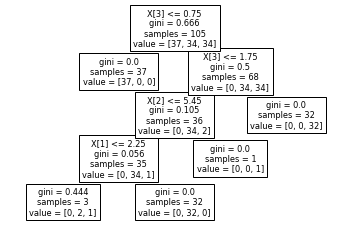

In [37]:
validation_metrics = {
    'accuracy': accuracy,
    'confusion_matrix': confusion_matrix,
    'plot_decision_tree': plot_decision_tree,
}
metrics_results = validate_model(validation_metrics, model, X_test, y_test, metrics_path=model_path)
metrics_results